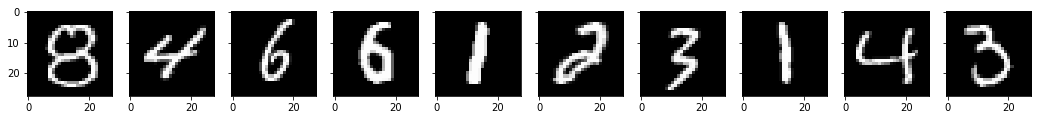

train data shape: (5000, 785), test data shape: (1000, 785)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

%matplotlib inline

def load_dataset(dataset_name):
    data = np.load('data/{}/{}.npz'.format(dataset_name.upper(), dataset_name))
    return data['X_train'], data['y_train'], data['X_test'], data['y_test']

X_train, y_train, X_test, y_test = load_dataset('mini_mnist')

f, ax = plt.subplots(1, 10, sharex='col', sharey='row',figsize=(18, 16))
for a in ax:
    a.imshow(X_train[np.random.randint(X_train.shape[0])].reshape(28, 28), cmap='gray')
plt.show()

X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
print("train data shape: {}, test data shape: {}".format(X_train.shape, X_test.shape))

### 2. Implementacja w Numpy

In [25]:
def np_linear(x, a):
    """
    Calculate l(x;a) in BxK
    :param x: Bx(D+1) input data
    :param a: Kx(D+1) weight matrix
    """
    return x @ a.T


def np_softmax(l):
    """
    Calculate p(l) in Bx
    :param l: BxK logits
    """
    exp_l = np.exp(l)
    div = exp_l.sum(axis=1)[:, np.newaxis]    
    return exp_l/div

def np_cross_entropy(p, y):
    """
    Calculate L(p,y)
    
    :param p: BxK predictions
    :param y: B true labels
    """
    n = y.shape[0]    
    l = -np.log(p[range(n),y])
    return np.sum(l) / n

def np_cross_entropy_grad(p, y, x):
    """
    Calculate dL/da in Kx(D+1)
    
    :param p: BxK predictions
    :param y: B true labels
    :param x: Bx(D+1) input data
    """
    n = y.shape[0]
    grad = np_softmax(p)
    grad[range(n),y] -= 1
    grad = grad/n
    print(grad)
    return grad

class NumpyLogisticRegression:
        
    def __init__(self, n_classes, n_epochs, input_size, learning_rate=0.1, batch_size=256):
        self.A = np.zeros((n_classes, input_size))
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_size = input_size
        self.n_classes = n_classes
        self.n_epochs = n_epochs
    
    def forward(self, x):
        x_pass = np_linear(x, self.A)
        x_pass = np_softmax(x_pass)
        return x_pass
    
    def train(self, X, Y, X_test=None, y_test=None):
        loss, train_accuracy, test_accuracy = [], [], []
        
        for e in tqdm(range(self.n_epochs)):
            
            perm = np.random.permutation(len(X))
            X, Y, = X[perm], Y[perm]
            
            for batch in range(len(X) // self.batch_size):
                x = X[batch * self.batch_size:(batch + 1) * self.batch_size]
                y = Y[batch * self.batch_size:(batch + 1) * self.batch_size]
                
                p = self.forward(x)
                l = np_cross_entropy(p, y)
                
                loss.append(l)
                train_accuracy.append(self.test(x, y))
                if X_test is not None and y_test is not None:
                    test_accuracy.append(self.test(X_test, y_test))
                
                grad_A = np_cross_entropy_grad(p, y, self.A)
                print(self.A.shape)
                print(grad_A.shape)
                self.A -= grad_A * self.learning_rate
                
        return loss, train_accuracy, test_accuracy
    
    def test(self, X, Y):
        p = np.argmax(self.forward(X), axis=1)
        return np.mean(p == Y)

In [9]:
clf = NumpyLogisticRegression(n_classes=10, n_epochs=10, input_size=785)
loss, train_accuracy, test_accuracy = clf.train(X_train, y_train, X_test, y_test)

  0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'exp'

In [10]:
def show_results(loss, train_accuracy, test_accuracy):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    ax1.set_title("Best test accuracy: {:.2f}%".format(max(test_accuracy) * 100))
    ax1.plot(train_accuracy, label='train accuracy')
    ax1.plot(test_accuracy, label='test accuracy')
    ax1.set_xlabel('steps')
    ax1.set_ylabel('accuracy')
    ax1.legend()

    ax2.set_title("Minimal loss: {:.4f}".format(min(loss)))
    ax2.plot(loss)
    ax2.set_xlabel('steps')
    ax2.set_ylabel('loss')

    plt.show()
    
show_results(loss, train_accuracy, test_accuracy)

NameError: name 'loss' is not defined

### Testy

In [26]:
x = np.array([[1.5, -2., 9.], [6., -1.2, 4.]])
A = np.array([
    [1., 2., 3.],
    [6., 5., 4.]
])

l = np.array([
    [ 24.5,  35. ],
    [ 15.6,  46. ]
])

p = np.array([
    [2.75356911e-05, 9.99972464e-01],
    [  6.27260226e-14,   1.]
])

y = np.array([0, 1])
ce = 5.250013768

# assert np.allclose(np_linear(x, A), l)
assert np.allclose(np_softmax(l), p)
assert np.allclose(np_cross_entropy(p, y), ce)

print("OK!")

OK!


### 2. Implementacja w PyTorchu

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
X_train = torch.tensor(X_train, dtype=torch.float, device=device)
X_test = torch.tensor(X_test, dtype=torch.float, device=device)
y_train = torch.tensor(y_train, dtype=torch.long, device=device)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)

In [14]:
def t_linear(x, a):
    """
    Calculate l(x;a) in BxK
    
    :param x: Bx(D+1) input data
    :param a: Kx(D+1) weight matrix
    """
    a_t = a.transpose(0,1)
    return x @ a_t
    
def t_softmax(l):
    """
    Calculate p(l) in BxK
    
    :param l: BxK logits
    """
    exp_l = l.exp()
    div = exp_l.sum(dim=1).unsqueeze(1)
    return exp_l/div

def t_cross_entropy(p, y):
    """
    Calculate L(p,y)
    
    :param p: BxK predictions
    :param y: B true labels
    """
    n = y.shape[0]    
    l = -p[range(n),y].log()
    return l.sum() / n

class TorchLogisticRegression:
    
    def __init__(self, n_classes, n_epochs, input_size, learning_rate=0.1, batch_size=256):
        self.A = torch.zeros((n_classes, input_size), requires_grad=True, device=device)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_size = input_size
        self.n_classes = n_classes
        self.n_epochs = n_epochs
    
    def forward(self, x):
        x_pass = t_linear(x, self.A)
        x_pass = t_softmax(x_pass)
        return x_pass
    
    def train(self, X, Y, X_test=None, y_test=None):
        loss, train_accuracy, test_accuracy = [], [], []
        
        for e in tqdm(range(self.n_epochs)):
            
            perm = torch.randperm(len(X))
            X, Y, = X[perm], Y[perm]
            
            for batch in range(len(X) // self.batch_size):
                x = X[batch * self.batch_size:(batch + 1) * self.batch_size]
                y = Y[batch * self.batch_size:(batch + 1) * self.batch_size]
                
                p = self.forward(x)
                l = t_cross_entropy(p, y)
                
                loss.append(l)
                train_accuracy.append(self.test(x, y))
                if X_test is not None and y_test is not None:
                    test_accuracy.append(self.test(X_test, y_test))
                
                # run backward from the loss
                print(l.backward())
                # grad_A = loss.backward()
                # self.A.data -= grad_A * self.learning_rate
                # zero gradients after calculations
                
        return loss, train_accuracy, test_accuracy
    
    def test(self, X, Y):
        p = torch.argmax(self.forward(X), dim=1)
        return torch.mean((p == Y).float())

In [15]:
clf = TorchLogisticRegression(n_classes=10, n_epochs=10, input_size=785)
loss, train_accuracy, test_accuracy = clf.train(X_train, y_train, X_test, y_test)

100%|██████████| 10/10 [00:03<00:00,  3.50it/s]


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


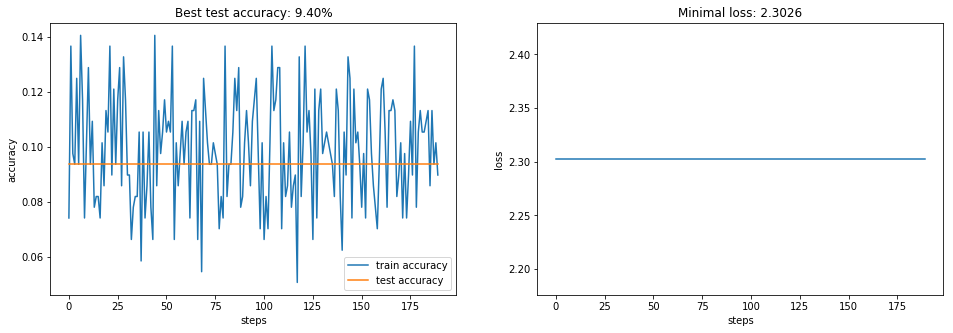

In [16]:
show_results(loss, train_accuracy, test_accuracy)

### Testy

In [19]:
tx = torch.Tensor([[1.5, -2., 9.], [6., -1.2, 4.]])
tA = torch.tensor([
    [1., 2., 3.],
    [6., 5., 4.]
], requires_grad=True, dtype=torch.float)
tl = torch.Tensor([
    [ 24.5,  35. ],
    [ 15.6,  46. ]
])
tp = torch.Tensor([
    [2.75356911e-05, 9.99972464e-01],
    [  6.27260226e-14,   1.]
])
ty = torch.LongTensor([0, 1])

assert torch.allclose(t_linear(tx, tA), tl)
assert torch.allclose(t_softmax(tl), torch.softmax(tl, dim=1))
assert torch.allclose(t_cross_entropy(tp, ty), torch.nn.CrossEntropyLoss()(tl, ty))

print("OK!")

OK!


### Oczekiwania od Rozwiązania

- Wykresy dla obu modeli (implementowanego w Numpy i PyTorchu) dają sensowe wykresy.
 - Przez sensowny wykres rozumiem, że funkcja kosztu maleje i wypłaszcza się, a dokładność wzrasta.
 - Wykresy dla obu modeli są podobne (modele powinny z założenia liczyć to samo z dokładnością do permutacji danych treningowych).
 - Dla domyślnych parametrów batch size i learning rate model powinien osiągać dokładność powyżej 86%.
- Zaimplementowane funkcje przechodzą wszystkie załączone testy.
- (opcjonalnie) Implementowane funkcje w Numpy powinny zawierać jak najmniej pętli ze względów wydajnościowych.